# LangGraph 中的控制流：并发分支

> 官方指南：https://langchain-ai.github.io/langgraph/how-tos/branching/ （附节点异步调用 [参考](https://github.com/langchain-ai/langgraph/issues/954)）

并发执行节点对于加快整体图操作至关重要。LangGraph 原生支持节点的并发执行，这可以显著提高基于图的工作流程的性能。

这种并发执行是通过扇出（Fan Out）和扇入（Fan In）模式完成的，利用了标准边和条件边。以下是一些示例，展示如何添加创建适用于您的分支数据流的方法。

## 并发节点的扇出和扇入：并发分支的步骤数量一致

在这个例子中，我们从节点 `A` 扩散到 `B` and `C` ，然后收敛到 `D` 。使用我们的状态，我们指定了 Reducer 的添加操作。这将结合或累积状态中特定键的值，而不是简单地覆盖现有值。对于列表，这意味着将新列表与现有列表连接起来。

> 请注意，LangGraph 使用 `Annotated` 类型来指定 State 中特定键的 Reducer 函数：它保留原始类型（`list`）以进行类型检查，但允许将 Reducer 函数（`add`）附加到类型上而不改变类型本身。

In [4]:
import operator
from typing import Annotated, Any

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")

builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")

builder.add_edge("d", END)
graph = builder.compile()

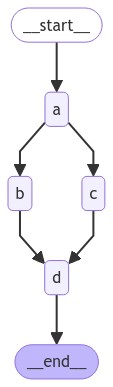

In [3]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [4]:
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## 并发节点的扇出和扇入：并发分支的步骤数量不一致

前一个示例展示了当每条路径只有一步时如何进行扇出和扇入。但如果并行路径中包含不同数量的步骤，那会发生什么呢？

In [6]:
import operator
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")

builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("b3", ReturnNodeValue("I'm B3"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("c2", ReturnNodeValue("I'm C2"))
builder.add_node("d", ReturnNodeValue("I'm D"))

builder.add_edge("a", "c")
builder.add_edge("c", "c2")
builder.add_edge("a", "b")
builder.add_edge("b", "b2")
builder.add_edge("b2", "b3")

# Make sure to use a group of nodes to fan in
builder.add_edge(["b3", "c2"], "d")

builder.add_edge("d", END)
graph = builder.compile()

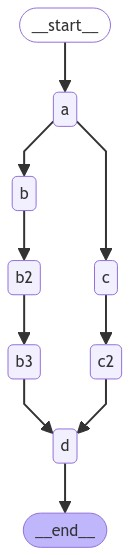

In [15]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [27]:
graph.invoke({"aggregate": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm C2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm B3 to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm C2"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm C2", "I'm B3"]


{'aggregate': ["I'm A",
  "I'm B",
  "I'm C",
  "I'm B2",
  "I'm C2",
  "I'm B3",
  "I'm D"]}

### LangGraph 的底层实现：Superstep

LangGraph 的底层图算法使用消息传递来定义一个通用程序。当一个节点完成其操作时，它会通过一条或多条边向其他节点发送消息。这些接收节点随后执行它们的函数，将产生的消息传递给下一组节点，这个过程持续进行。

受到 Google 的 [Pregel](https://research.google/pubs/pregel-a-system-for-large-scale-graph-processing/) 系统的启发，该程序以离散的“超级步骤”（[Superstep](https://www.genspark.ai/spark?id=65ef9a68-2be5-4d83-a6b1-b6df7d547d6e&is_editing=false)）进行。一个节点可以有多个扇出边。如果一个节点有多个扇出边，**所有这些目标节点都将作为下一个超级步骤的一部分并发执行**。

> LangGraph 的 Pregel 实现：https://github.com/langchain-ai/langgraph/tree/main/libs/langgraph/langgraph/pregel

### 本例的扇出和扇入执行步骤解析

基于 Superstep 的概念，我们分步来解析本例的执行过程：

1. 节点 `A` 执行完成，扇出两个需要并行执行的节点 `B` 和 `C`
    - `B` 和 `C` 一起构成下一个待执行的超级步骤
1. 节点 `B` 执行完成，流转后续节点 `B2`；节点 `C` 执行完成，流转后续节点 `C2`
    - `B2` 和 `C2` 一起构成下一个待执行的超级步骤
1. 节点 `B2` 执行完成，流转后续节点 `B3`；节点 `C2` 执行完成，流转后续节点 `D`
    - `B3` 和 `D` 一起构成下一个待执行的超级步骤
1. 节点 `B3` 执行完成，流转后续节点 `D`；节点 `D` 需要同时具有 `B3` 和 `C2` 的执行结果作为输入，继续等待
    - `D` 独自成为一下待执行的超级步骤
1. 节点 `D` 在同时具有了 `B3` 和 `C2` 的输入后完成执行，流转后续节点 `END`

## 通过条件分支进行动态扇出

如果您扇出（fan-out）不是确定的，您可以直接使用 `add_conditional_edges`。

如果您有一个已知的扇入节点，条件分支之后会路由到该节点，您可以在创建条件边时提供第四个参数或 `then=<final-node-name>` 。

In [7]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    which: str


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]


intermediates = ["b", "c", "d"]
builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    intermediates,
    "e"
)
# for node in intermediates:
#     builder.add_edge(node, "e")


builder.add_edge("e", END)
graph = builder.compile()

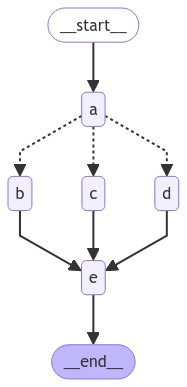

In [8]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [9]:
graph.invoke({"aggregate": [], "which": "bc"})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm E to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm E"], 'which': 'bc'}

In [10]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A"]
Adding I'm E to ["I'm A", "I'm C", "I'm D"]


{'aggregate': ["I'm A", "I'm C", "I'm D", "I'm E"], 'which': 'cd'}

## 对扇出的执行结果进行稳定排序

如果您需要从并发分支的执行结果中获取一致的、预定的更新顺序，您应该将输出（连同标识键）写入您状态的一个单独字段中，然后在扇入节点中将每个扇出节点的汇聚结果进行二次处理（如排序）。

In [11]:
import operator
from typing import Annotated, Sequence

from typing_extensions import TypedDict

from langgraph.graph import StateGraph


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    fanout_values: Annotated[list, operator.add]
    which: str


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")


class ParallelReturnNodeValue:
    def __init__(
        self,
        node_secret: str,
        reliability: float,
    ):
        self._value = node_secret
        self._reliability = reliability

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']} in parallel.")
        return {
            "fanout_values": [
                {
                    "value": [self._value],
                    "reliability": self._reliability,
                }
            ]
        }

builder.add_node("b", ParallelReturnNodeValue("I'm B", reliability=0.9))
builder.add_node("c", ParallelReturnNodeValue("I'm C", reliability=0.1))
builder.add_node("d", ParallelReturnNodeValue("I'm D", reliability=0.3))

# Define fan-in aggregation handler
def aggregate_fanout_values(state: State) -> Any:
    # Sort by reliability
    ranked_values = sorted(
        state["fanout_values"], key=lambda x: x["reliability"], reverse=True
    )
    return {
        "aggregate": [x["value"] for x in ranked_values] + ["I'm E"],
        "fanout_values": [],
    }

builder.add_node("e", aggregate_fanout_values)


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]

intermediates = ["b", "c", "d"]
builder.add_conditional_edges("a", route_bc_or_cd, intermediates, "e")


builder.add_edge("e", END)
graph = builder.compile()

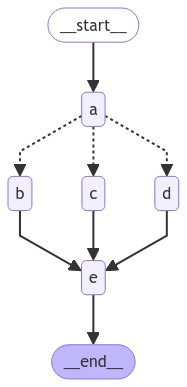

In [12]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [13]:
graph.invoke({"aggregate": [], "which": "bc", "fanout_values": []})

Adding I'm A to []
Adding I'm B to ["I'm A"] in parallel.
Adding I'm C to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm B"], ["I'm C"], "I'm E"],
 'fanout_values': [{'value': ["I'm B"], 'reliability': 0.9},
  {'value': ["I'm C"], 'reliability': 0.1}],
 'which': 'bc'}

In [14]:
graph.invoke({"aggregate": [], "which": "cd", "fanout_values": []})

Adding I'm A to []
Adding I'm C to ["I'm A"] in parallel.
Adding I'm D to ["I'm A"] in parallel.


{'aggregate': ["I'm A", ["I'm D"], ["I'm C"], "I'm E"],
 'fanout_values': [{'value': ["I'm C"], 'reliability': 0.1},
  {'value': ["I'm D"], 'reliability': 0.3}],
 'which': 'cd'}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e6124301-0a3c-4c43-a70b-884a597351fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>